# Deepfake Classification

# Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
from tabulate import tabulate
import os
import glob
import json
from sklearn import metrics
import shutil

# Config

The Config class was created to store the configurations used in the model. Each attribute of the class represents a specific configuration used during training.

In [ ]:
class Config:
    def __init__(self):
        self.image_width = 128
        self.image_height = 128
        self.epoch = 15
        self.seed = 42
        self.batch_size = 64
        self.dataset_path = '/Dataset/real_vs_fake/real-vs-fake/'
        self.checkpoint_filepath = 'model_checkpoint.h5'
        self.logs_path = '/kaggle/working/logs'

In [ ]:
config = Config()

In [ ]:
if os.path.exists(config.logs_path):
    shutil.rmtree(config.logs_path)

# Dataset

Initially the dataset is loaded into a dataframe in order to be able to analyze it.

In [ ]:
dataset = {"image_path":[],"img_status":[],"where":[]}
for where in os.listdir(config.dataset_path):
    for status in os.listdir(config.dataset_path+"/"+where):
        for image in glob.glob(config.dataset_path+where+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)

In [ ]:
dataset.head()

,image_path,img_status,where
0,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
1,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
2,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
3,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
4,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid


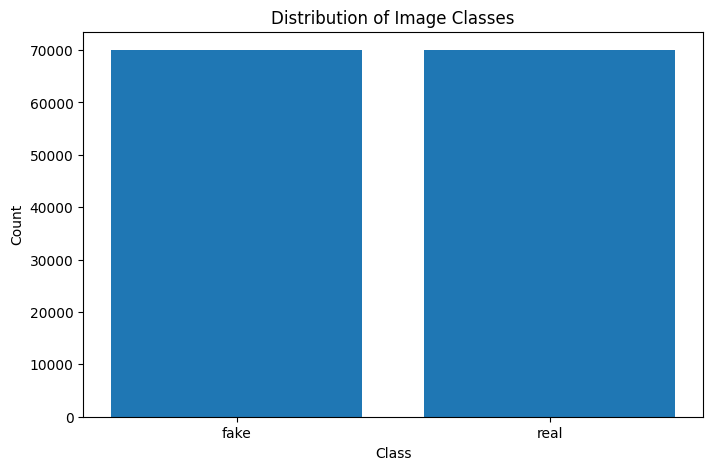

In [ ]:
status_counts = dataset["img_status"].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(status_counts.index, status_counts)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Image Classes")
plt.show()

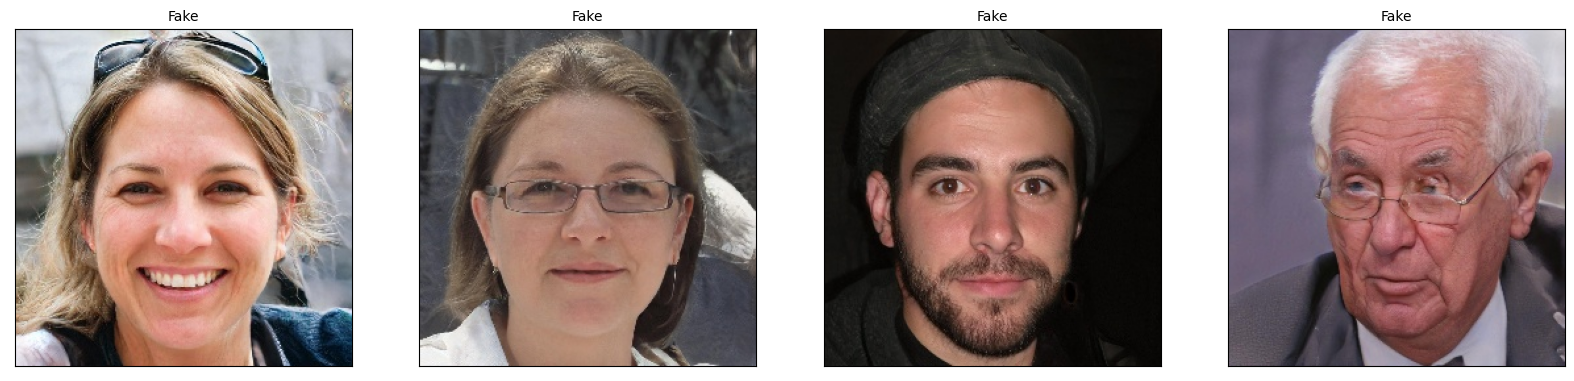

In [ ]:
plt.figure(figsize=(20, 10))

fake_images = dataset[dataset['img_status'] == 'fake'].sample(4)
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(plt.imread(fake_images["image_path"].values[i]))
    plt.title('Fake', size=10)
    plt.xticks([])
    plt.yticks([])

plt.show()

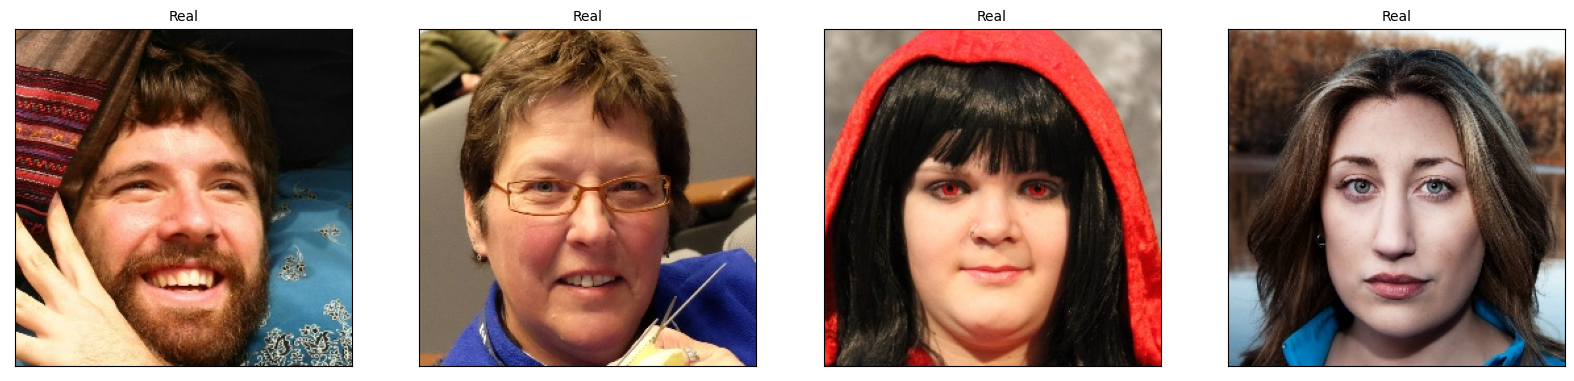

In [ ]:
plt.figure(figsize=(20, 10))

real_images = dataset[dataset['img_status'] == 'real'].sample(4)
for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.imshow(plt.imread(real_images["image_path"].values[i]))
    plt.title('Real', size=10)
    plt.xticks([])
    plt.yticks([])

plt.show()


# Data Augmentation

Before proceeding with the training of the model, the data were subjected to augmentation in order to increase the variability within them. This allows to obtain a model that is more generalized and robust

In [ ]:
image_gen = ImageDataGenerator(
    vertical_flip=False,
    horizontal_flip=True,
    rescale=1./255
)

In [ ]:
train_generator = image_gen.flow_from_directory(
    config.dataset_path + 'train/',
    target_size=(config.image_width, config.image_height),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    seed=config.seed
)

Found 100000 images belonging to 2 classes.


In [ ]:
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    config.dataset_path + 'valid/',
    target_size=(config.image_width, config.image_height),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.


In [ ]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    config.dataset_path + 'test/',
    target_size=(config.image_width, config.image_height),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


We will indicate with class 0 all those images classified as fake, vice versa with class 1 we will indicate those images that represent real faces.

In [ ]:
def show_training_images(generator):
    images, labels = generator.next()
    labels = labels.astype(int)

    label_names = ['Fake', 'Real']
    label_names = [label_names[label] for label in labels]

    fig, axes = plt.subplots(1, 4)
    axes = axes.ravel()

    for i in range(len(axes)):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        axes[i].set_title(format(label_names[i]))
        axes[i].figure.set_size_inches(15,15)

    plt.tight_layout()
    plt.show()


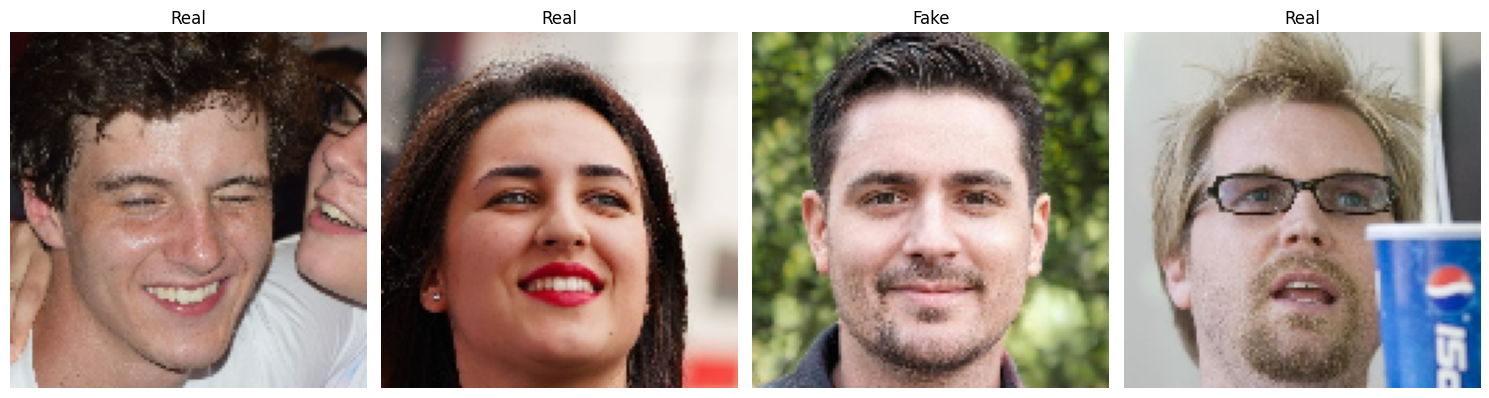

In [ ]:
show_training_images(train_generator)

# Modelling

The model involves the use of a resNet50, which was used as a fixed feature extractor. Subsequently, final layers were added for binary classification

In [ ]:
resNet = ResNet50(weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)




94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    resNet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

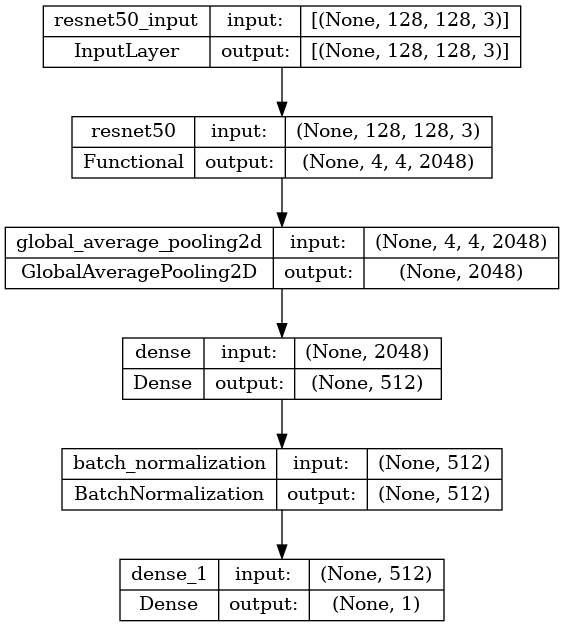

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"



_________________________________________________________________



 Layer (type)                Output Shape              Param #   






 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  



                                                                 



 global_average_pooling2d (G  (None, 2048)             0         



 lobalAveragePooling2D)                                          



                                                                 



 dense (Dense)               (None, 512)               1049088   



                                                                 



 batch_normalization (BatchN  (None, 512)              2048      



 ormalization)                                                   



                                                                 



 dense_1 (Dense)             (None, 1)                 513       



                                                                 






Total

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

## Callbacks

Next, the model callbacks are initialized, which help in the training phase through numerous adjustments on the hyperparameters

In [ ]:
checkpoint_callback = ModelCheckpoint(config.checkpoint_filepath,
                                      monitor='val_loss',
                                      save_weights_only=True,
                                      save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001
                             )

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               verbose=1,
                               restore_best_weights=True
                              )

tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

callbacks = [tensorboard_callback, reduce_lr, early_stopping, checkpoint_callback]

# Training

In [ ]:
class ModelTrainer:
    def __init__(self, model, train_generator, valid_generator, config, callbacks):
        self.model = model
        self.train_generator = train_generator
        self.valid_generator = valid_generator
        self.steps_per_epoch = train_generator.n // config.batch_size
        self.validation_steps = valid_generator.n // config.batch_size
        self.epochs = config.epoch
        self.callbacks = callbacks

    def train(self):
        history = self.model.fit(
            self.train_generator,
            steps_per_epoch=self.steps_per_epoch,
            validation_data=self.valid_generator,
            validation_steps=self.validation_steps,
            epochs=self.epochs,
            callbacks=self.callbacks
        )
        return history


In [ ]:
trainer = ModelTrainer(model, train_generator, valid_generator, config, callbacks)
history = trainer.train()

Epoch 1/15



1562/1562 [==============================] - 898s 549ms/step - loss: 0.2749 - accuracy: 0.8817 - val_loss: 0.2349 - val_accuracy: 0.9008 - lr: 0.0010



Epoch 2/15



1562/1562 [==============================] - 257s 164ms/step - loss: 0.1401 - accuracy: 0.9440 - val_loss: 0.2841 - val_accuracy: 0.8885 - lr: 0.0010



Epoch 3/15



1562/1562 [==============================] - 264s 169ms/step - loss: 0.1052 - accuracy: 0.9588 - val_loss: 1.0029 - val_accuracy: 0.6551 - lr: 0.0010



Epoch 4/15



1562/1562 [==============================] - ETA: 0s - loss: 0.0813 - accuracy: 0.9692



Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



1562/1562 [==============================] - 279s 179ms/step - loss: 0.0813 - accuracy: 0.9692 - val_loss: 0.2541 - val_accuracy: 0.8959 - lr: 0.0010



Epoch 5/15



1562/1562 [==============================] - 260s 167ms/step - loss: 0.0277 - accuracy: 0.9900 - val_loss: 0.0461 - val_accuracy: 0.9838 - lr: 2.000

In [ ]:
model.save(config.checkpoint_filepath)

After training, the model is saved, using the weights that performed best on the validation set.

## Analysis of results

The loss curves of the model and the accuracy obtained for both the training and validation sets were analyzed.

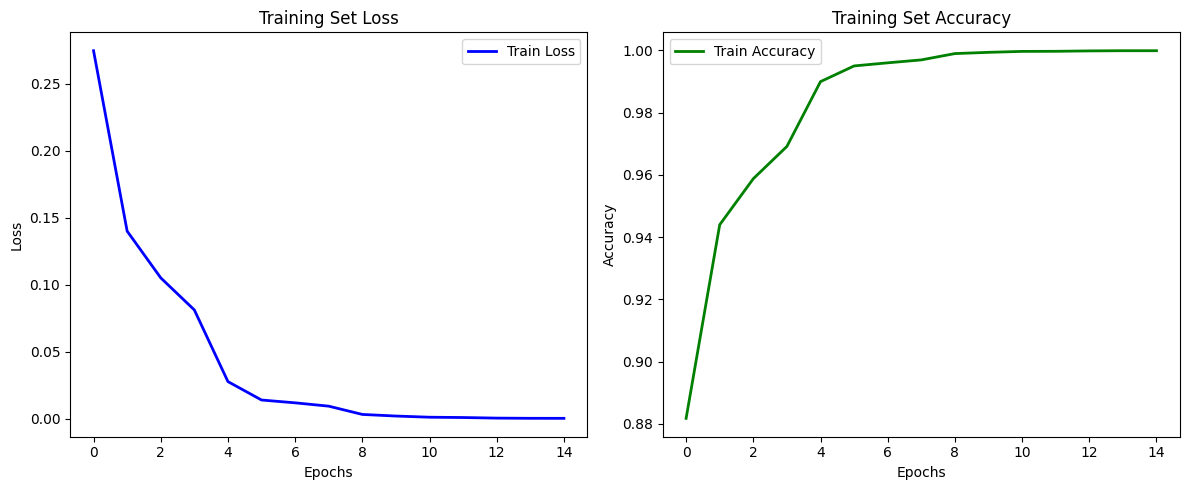

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', linewidth=2, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Set Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy', linewidth=2, color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Set Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


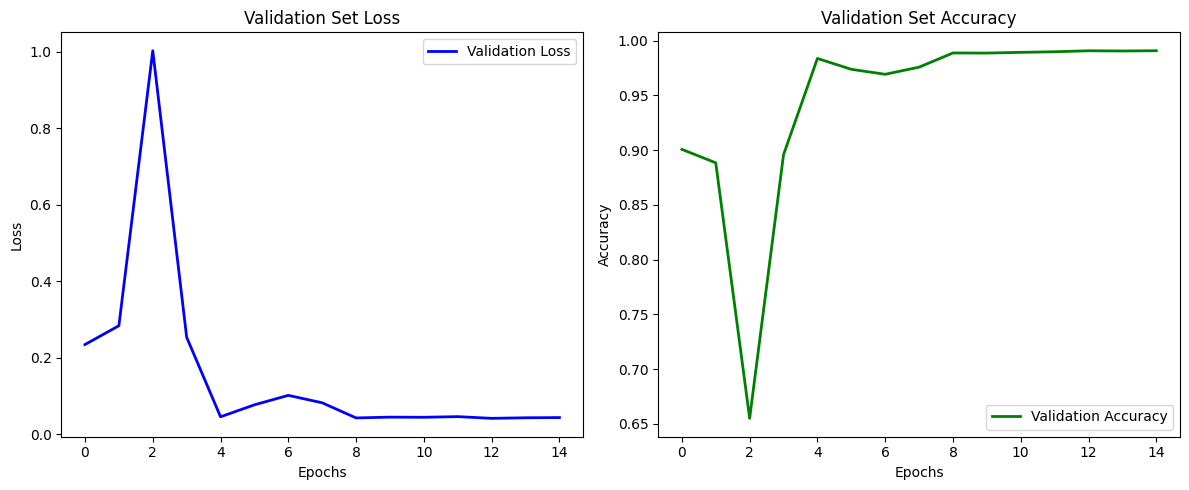

In [ ]:
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(val_loss, label='Validation Loss', linewidth=2, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Set Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Validation Accuracy', linewidth=2, color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
mean_loss = sum(history.history['loss']) / len(history.history['loss'])
mean_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
table = [
    ['Mean Loss', mean_loss],
    ['Mean Accuracy', mean_accuracy],
]

print(tabulate(table, headers=['Metric', 'Value'], tablefmt='fancy_grid'))

╒═══════════════╤═══════════╕



│ Metric        │     Value │



╞═══════════════╪═══════════╡



│ Mean Loss     │ 0.0448375 │



├───────────────┼───────────┤



│ Mean Accuracy │ 0.981954  │



╘═══════════════╧═══════════╛


## Test Evaluation

In [ ]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

20000/20000 [==============================] - 197s 10ms/step


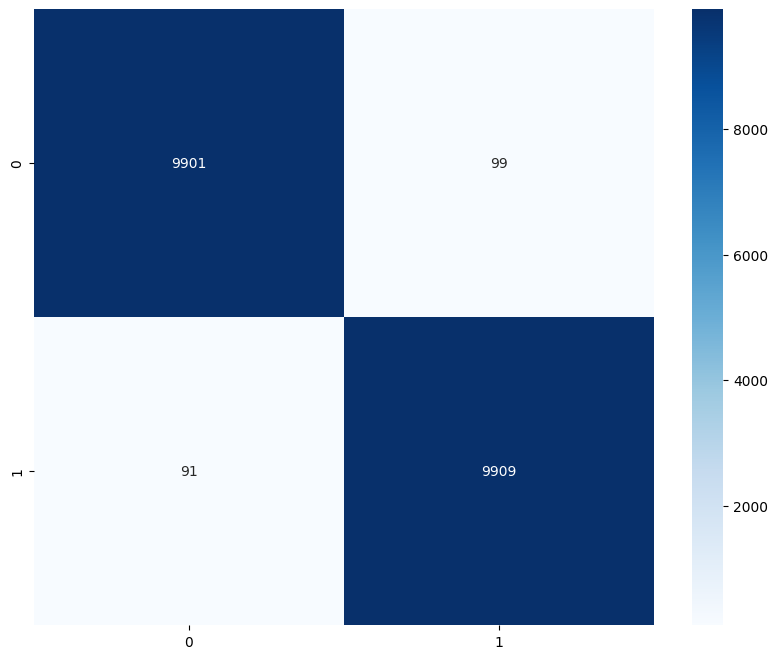

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [ ]:
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support







           0       0.99      0.99      0.99     10000



           1       0.99      0.99      0.99     10000







    accuracy                           0.99     20000



   macro avg       0.99      0.99      0.99     20000



weighted avg       0.99      0.99      0.99     20000






# Live Test


Below is a small test that chooses random images from the test set and predicts their labels.

In [ ]:
model_path = '/kaggle/input/ig-model/model_checkpoint.h5'
model = keras.models.load_model(model_path)

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    config.dataset_path + 'test/',
    target_size=(config.image_width, config.image_height),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [ ]:
num_images = len(test_generator.filenames)
num_random_images = 5
random_indices = np.random.choice(num_images, size=num_random_images, replace=False)

predictions = []
labels = []
predicted_labels = []

In [ ]:
for index in random_indices:
    image, label = test_generator[index]
    prediction = model.predict(image)
    predictions.append(prediction)
    labels.append(label)
    predicted_labels.append(prediction > 0.5)

predictions = np.array(predictions)
labels = np.array(labels)
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 0s 29ms/step


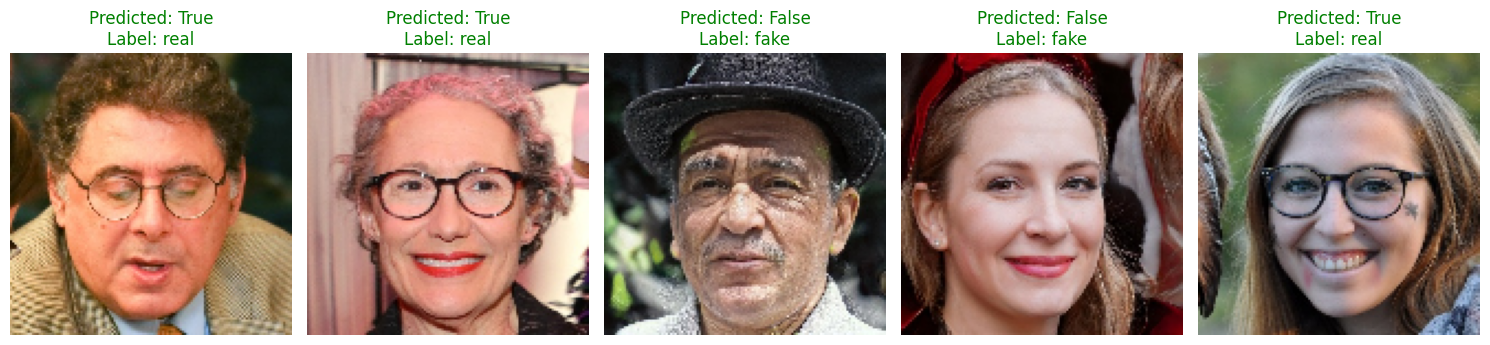

In [ ]:
fig, axes = plt.subplots(1, num_random_images, figsize=(15, 5))

for i in range(num_random_images):
    image = np.squeeze(test_generator[random_indices[i]][0][0])
    ax = axes[i]
    ax.imshow(image)
    ax.axis('off')
    if predicted_labels[i] == labels[i]:
        color = 'green'
    else:
        color = 'red'
    if labels[i] == 1:
        label_text = "real"
    else:
        label_text = "fake"
    ax.set_title(f'Predicted: {predicted_labels[i][0][0]}\nLabel: {label_text}', color=color)

plt.tight_layout()
plt.show()